In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [4]:
os.getcwd()

'/home/nbuser'

In [5]:
import pandas as pd
labels=pd.read_csv('labels.csv')
n=len(labels)
labels.head()
val_idxs = get_cv_idxs(n)

In [6]:
labels.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


# model build

In [7]:
PATH='./'
val_idxs = get_cv_idxs(n)
bs=50
arch=resnet101
sz=124
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.0)
data=ImageClassifierData.from_csv(path=PATH,folder='train',csv_fname='labels.csv',tfms=tfms,val_idxs=val_idxs,suffix='.jpg',
                             test_name='test',skip_header=True)

In [8]:
learn = ConvLearner.pretrained(arch, data=data, precompute=True)
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.624791   0.997843   0.727984  
    1      1.027207   0.877019   0.75636                    



[array([0.87702]), 0.7563600776946708]

In [9]:
lr=learn.lr_find()

 88%|████████▊ | 113/128 [00:08<00:01, 14.08it/s, loss=3.71]


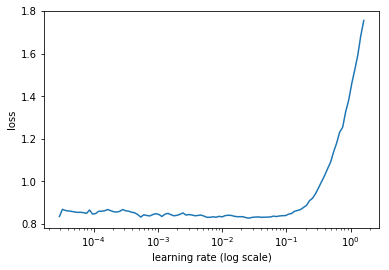

In [10]:
learn.sched.plot()

In [11]:
learn.precompute = False

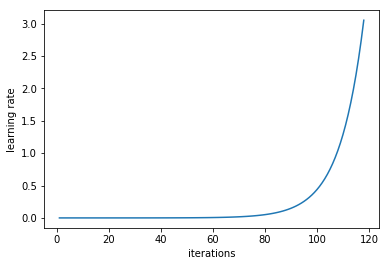

In [12]:
learn.sched.plot_lr()

In [18]:
lrn=np.array([1e-8,1e-4,1e-2])
learn.fit(lrn, 3, cycle_len=1,cycle_mult=2)

  4%|▍         | 5/128 [00:03<01:35,  1.28it/s, loss=0.908]
epoch      trn_loss   val_loss   accuracy                    
    0      0.976632   0.833085   0.762231  
    1      0.944867   0.826495   0.75636                     
    2      0.843079   0.817742   0.758806                    
    3      0.870216   0.831629   0.763209                    
    4      0.798271   0.811779   0.761742                    
    5      0.73809    0.796248   0.772505                    
    6      0.70235    0.797622   0.766634                    



[array([0.79762]), 0.766634050763983]

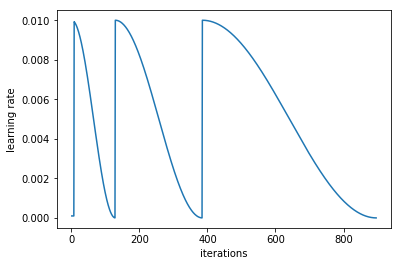

In [19]:
learn.sched.plot_lr()

In [20]:
learn.unfreeze()

In [25]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH,folder='train', csv_fname='labels.csv', tfms=tfms,
                    val_idxs=val_idxs,suffix='.jpg',test_name='test',skip_header=True)


In [27]:
#increase size ,unfreeze initial layers
learn.set_data(get_data(220),precompute=False)
learn.unfreeze

<bound method ConvLearner.unfreeze of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [28]:
#set earlier layers to 3-10 times smaller than nxt level layer
learn.fit(lrn,2,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.450316   0.36719    0.887476  
    1      0.394235   0.358503   0.886497                    
    2      0.35616    0.354941   0.888943                    



[array([0.35494]), 0.8889432482990034]

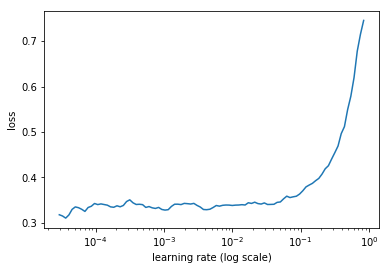

In [31]:
#lr=learn.lr_find()
learn.sched.plot()

In [37]:
learn.fit(lrn,3,cycle_len=1,cycle_mult=3)

  5%|▍         | 6/128 [00:07<02:38,  1.30s/it, loss=0.329]
epoch      trn_loss   val_loss   accuracy                    
    0      0.348249   0.353818   0.887476  
    1      0.339608   0.355852   0.886497                    
    2      0.307887   0.343814   0.892857                    
    3      0.287876   0.34375    0.892857                    
    4      0.294128   0.349549   0.889432                    
    5      0.28287    0.349972   0.888943                    
 80%|███████▉  | 102/128 [01:32<00:23,  1.11it/s, loss=0.252]

KeyboardInterrupt: 

In [38]:
learn.save('224_2_pre')

In [ ]:
learn.load('224_pre')

# prediction & submission

In [63]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [64]:
probs.shape

(10357, 120)

In [65]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [66]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [67]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,9d591f86fdd00f9731dc51d68c7b6323,2.569325e-08,4.670987e-06,4.340347e-07,9.971727e-01,8.999432e-09,1.440023e-07,3.260041e-07,1.347868e-06,1.665552e-08,...,3.110160e-07,3.183662e-08,9.506925e-07,2.075985e-07,1.272354e-07,2.303841e-07,3.161333e-08,5.474879e-07,0.000357,3.083568e-06
1,6893b5ed882c7ae791e4a440f613a3f8,9.947901e-01,7.446357e-06,6.029600e-06,9.522311e-06,9.788967e-07,2.191762e-05,2.570871e-06,9.267030e-07,4.655507e-07,...,4.945138e-06,3.335566e-07,3.605076e-06,2.886662e-07,2.292899e-06,7.775250e-07,5.561643e-07,1.850599e-06,0.000023,1.201979e-04
2,2a1c95b9f131236b715df75ff815fd0b,3.862590e-06,4.659467e-04,2.954821e-06,9.411518e-06,1.186816e-07,4.626534e-06,1.284951e-05,1.287894e-07,1.096030e-06,...,3.537169e-05,4.360702e-06,3.347074e-06,1.298851e-06,2.112485e-06,4.247743e-05,4.000209e-06,1.396557e-06,0.000012,1.077891e-04
3,87e96ca57ae92a499e057debb62fc232,7.861647e-05,8.367839e-07,6.479817e-07,5.962651e-07,1.889845e-07,1.782070e-06,1.534362e-06,9.179274e-07,3.325103e-06,...,4.673440e-05,1.036617e-06,1.156463e-05,8.179512e-07,2.257932e-07,1.239312e-06,6.030114e-06,9.904075e-08,0.000002,2.398151e-05
4,d2da98041804728e98d85b9ee42571a3,2.904607e-08,3.821632e-07,6.988105e-08,3.911676e-06,1.430220e-07,1.211782e-07,6.286352e-08,3.323326e-08,5.545330e-08,...,9.359486e-06,3.410316e-07,1.165762e-07,4.081519e-08,5.272308e-06,1.957620e-07,4.276474e-07,7.570611e-07,0.000020,8.014216e-09


In [68]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [69]:
FileLink(f'{SUBM}subm.gz')

/home/nbuser/subm/subm.gz

# test singleimage

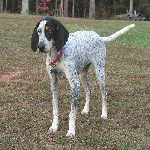

In [74]:
fn = data.val_ds.fnames[1]            #taking out 1 image
Image.open(PATH + fn).resize((150, 150))   #making it small to reduce compute time

In [75]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)     #converting image to an necessary fmt by architecture & outputs array of values for a image
im = val_tfms(open_image(PATH + fn))                # open_image() of numpy.ndarray
preds = learn.predict_array(im[None])            #im[none] converts 4 dim values(no.of image,row,col,channel)/4dim tensor 
                                                            #into 1 minibatch as the syntax expects(since usually there would be minibatch no. of images after model) 
                                                    
np.argmax(preds)
data.classes[np.argmax(preds)]

'bluetick'